La barrera hematoencefálica es una barrera fisiológica que restringe qué moléculas entran en el sistema nervioso central. Su predicción de permeabilidad juega un rol en el diseño de fármaco del SNC, en pruebas toxicológica y estudios de farmacocinética.

El objetivo es construir un modelo QSAR (Quantitative Structure-Activity Relationship), que relacione la estructura química con su capacidad de atravesar la barrera.

In [19]:
!pip install kagglehub -q

import kagglehub

# Descargar el dataset BBBP
path = kagglehub.dataset_download("priyanagda/bbbp-smiles")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bbbp-smiles' dataset.
Path to dataset files: /kaggle/input/bbbp-smiles


In [20]:
#Cargar librería para el CSV

import pandas as pd
import os

# Buscat el archivo CSV
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_path = os.path.join(path, file)
        print("Archivo encontrado:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Archivo encontrado: /kaggle/input/bbbp-smiles/BBBP.csv


,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


En el contexto químico, SMILES es la representación textual de la estructura química.

# 1. Análisis exploratorio y limpieza de datos

In [21]:
#Renombre de columnas

df = df.rename(columns={'smiles': 'SMILES', 'p_np': 'label'})

In [22]:
#Tamaño

print("Filas totales:", df.shape[0])

Filas totales: 2050


In [23]:
#Eliminar filas sin SMILES válidos
df = df.dropna(subset=['SMILES'])

In [24]:
#labels a int
df['label'] = df['label'].astype(int)

In [25]:
#Visualización
df.head()

,num,name,label,SMILES
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


# 2. Uso de RDkit para conversión de moléculas a validar

In [26]:
#Instalar librerías
!pip install rdkit -q

#Importar librerías

from rdkit import Chem

def smi_to_mol(smi):
    try:
        return Chem.MolFromSmiles(smi)
    except:
        return None

df['mol'] = df['SMILES'].apply(smi_to_mol)

# Filtrar moléculas válidas

df= df[df['mol'].notna()]

# Número de moléculas válidas

print("Moléculas válidas:", df.shape[0])
df.head()

[20:32:09] Explicit valence for atom # 1 N, 4, is greater than permitted
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] Explicit valence for atom # 6 N, 4, is greater than permitted
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] Explicit valence for atom # 6 N, 4, is greater than permitted
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] WARNING: not removing hydrogen atom without neighbors
[20:32:09] Explicit valence for atom # 11 N, 4, is greater than pe

Moléculas válidas: 2039


[20:32:10] WARNING: not removing hydrogen atom without neighbors
[20:32:10] WARNING: not removing hydrogen atom without neighbors


,num,name,label,SMILES,mol
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,<rdkit.Chem.rdchem.Mol object at 0x7d8082083c30>
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,<rdkit.Chem.rdchem.Mol object at 0x7d8082083bc0>
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,<rdkit.Chem.rdchem.Mol object at 0x7d8081f59fc0>
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,<rdkit.Chem.rdchem.Mol object at 0x7d8081f5a730>
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,<rdkit.Chem.rdchem.Mol object at 0x7d8081f5a0a0>


RDkit convierte los strings en objetos moleculares con información de interacción de átomos, enlaces, aromaticidad y genera descriptores químicos

# 3. Crear descriptores moleculares

Los morgan fingerprints son representaciones numéricas de moléculas basadas en sus subsestructura químicas. Captura patrones aromáticos, grupos funcionales y características locales de estructura

In [27]:
from rdkit.Chem import AllChem
import numpy as np

#Definir mol a fp, con radio 2 por 2 enlaces alrededor de cada átomo
def mol_to_fp(mol, radius=2, n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

X = np.array([mol_to_fp(m) for m in df['mol']])
y = df['label'].values

X.shape, y.shape

[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerator
[20:32:10] DEPRECATION WARNING: please use MorganGenerat

((2039, 2048), (2039,))

# 4. Entrenamiento/Prueba

In [28]:
#importar librería para entrenamiento

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28, stratify=y
)

#Conocer cuántos datos serán entrenados y cuántos testeados
print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (1631, 2048)
Test: (408, 2048)


La elección de Random Forest se debe al tamaño reducido del data set y a que los fingerprints son binarios

In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=28,
    class_weight='balanced'
)

model.fit(X_train, y_train)

#Comprobación de entrenamiento

print("Modelo entrenado")

Modelo entrenado


#5. Evaluación del modelo

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.65      0.74        96
           1       0.90      0.97      0.93       312

    accuracy                           0.89       408
   macro avg       0.88      0.81      0.84       408
weighted avg       0.89      0.89      0.89       408

ROC AUC: 0.926665998931624


# 6. Matriz de confusión

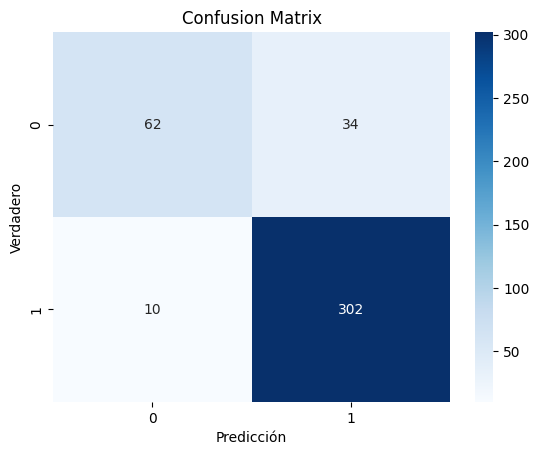

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()


## El modelo presenta una capacidad de discriminación entre moléculas que cruzan o no la barrera hematoencefálica, mayor al 90%.

La clase 1, que cruza la barrera, presenta un recall de 97%, por lo que es casi todas las moléculas positivas. De hecho, con una precisión del 90%, sólo 1 de cada 10 predicciones positivas es un falso positivo.

En la clase 0 se presenta una tendencia a sobrepredecir permeabilidad, con un recall del 61%, esto puede deberse a la cantidad de moléculas permeables en el dataset, y que la permeabilidad puede depender de propiedades globales que no se captura en el dataset, como peso molecular, logP (la capacidad de un fármaco para distribuirse entre dos fases inmiscibles).

Sin embargo, el pipeline es reproducible, usa estándares industriales que pueden ser útiles para herramienta de cribado temprano.

# 7. Guardado del modelo

In [32]:
import joblib

joblib.dump(model, "bbbp_model.pkl")
print("Modelo guardado como bbbp_model.pkl")


Modelo guardado como bbbp_model.pkl
